<a href="https://colab.research.google.com/github/sushily1997/Crop_Prediction_System-/blob/main/Crop_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Importing required modules


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import r2_score
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# **Data** **Loading**


In [2]:
df = pd.read_csv('Crop_recommendation.csv')
print('Data Shape: ', df.shape)

Data Shape:  (2200, 8)


In [3]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# **Data fields**

N - ratio of Nitrogen content in soil

P - ratio of Phosphorous content in soil

K - ratio of Potassium content in soil

temperature - temperature in degree Celsius

humidity - relative humidity in %

ph - ph value of the soil

rainfall - rainfall in mm


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


**Observation:** Clearly there are no missing values. And also, the data is equally distributed.


In [5]:
df.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [6]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [7]:

crops = df['label'].unique()
crops.sort()
print ("Total Number of Crops Data: ", len(crops) )
print("\n","-"*20, " List of Crops ", "-"*20)
crops.tolist()

Total Number of Crops Data:  22

 --------------------  List of Crops  --------------------


['apple',
 'banana',
 'blackgram',
 'chickpea',
 'coconut',
 'coffee',
 'cotton',
 'grapes',
 'jute',
 'kidneybeans',
 'lentil',
 'maize',
 'mango',
 'mothbeans',
 'mungbean',
 'muskmelon',
 'orange',
 'papaya',
 'pigeonpeas',
 'pomegranate',
 'rice',
 'watermelon']

In [8]:
df.label.unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [9]:
# get top 5 most frequent growing crops
n = 5
df['label'].value_counts()[:5].index.tolist()

['rice', 'maize', 'jute', 'cotton', 'coconut']

In [10]:
# Number of Rows against each Crop
print("Number of Records Against Eash Crop")
print("-"*35)
print(df['label'].value_counts() )

Number of Records Against Eash Crop
-----------------------------------
label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64


In [11]:
#Columns Name
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [12]:
# Features Selection
selected_features = {'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'}
selected_features

{'K', 'N', 'P', 'humidity', 'ph', 'rainfall', 'temperature'}

In [13]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


**Observation:** Since Mean and Median are almost similar, no scaling is required.


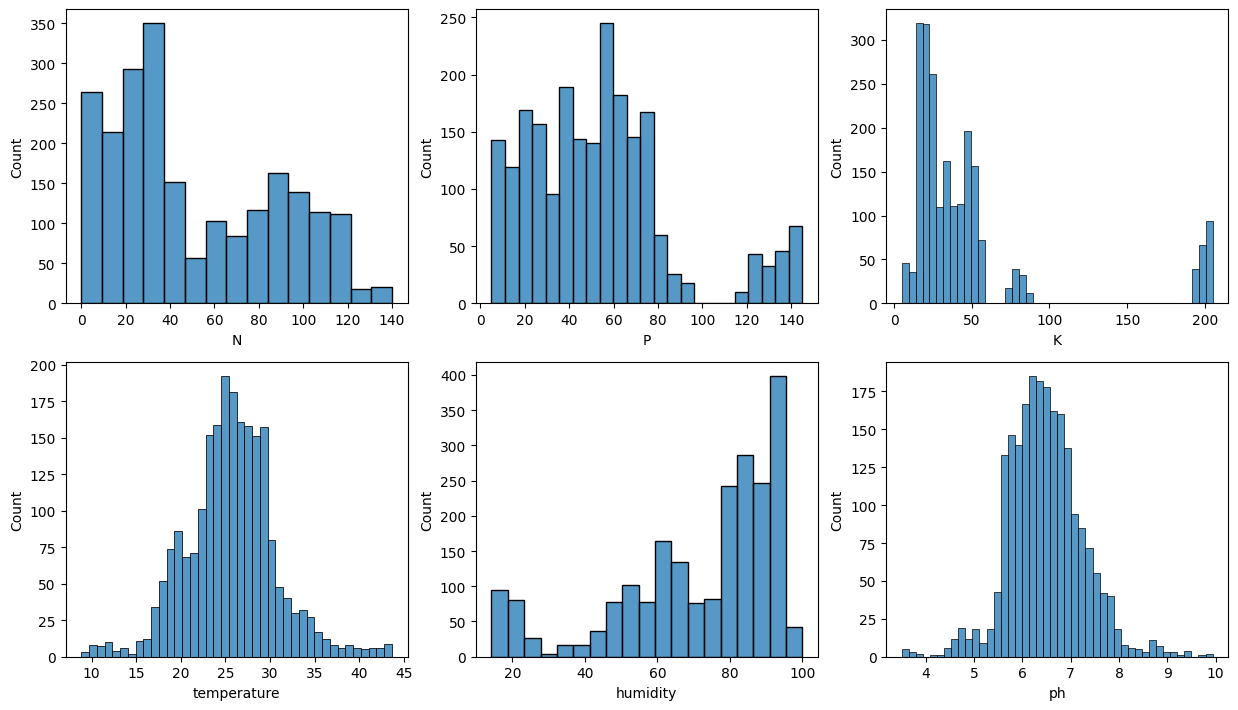

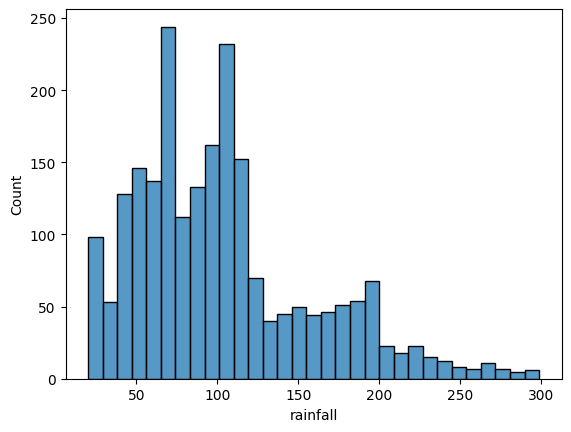

In [14]:
all_columns = df.columns[:-1]

plt.figure(figsize=(15,13))
i = 1
for column in all_columns[:-1]:
    plt.subplot(3,3,i)
    sns.histplot(df[column])
    i+=1
plt.show()

sns.histplot(df[all_columns[-1]])
plt.show()

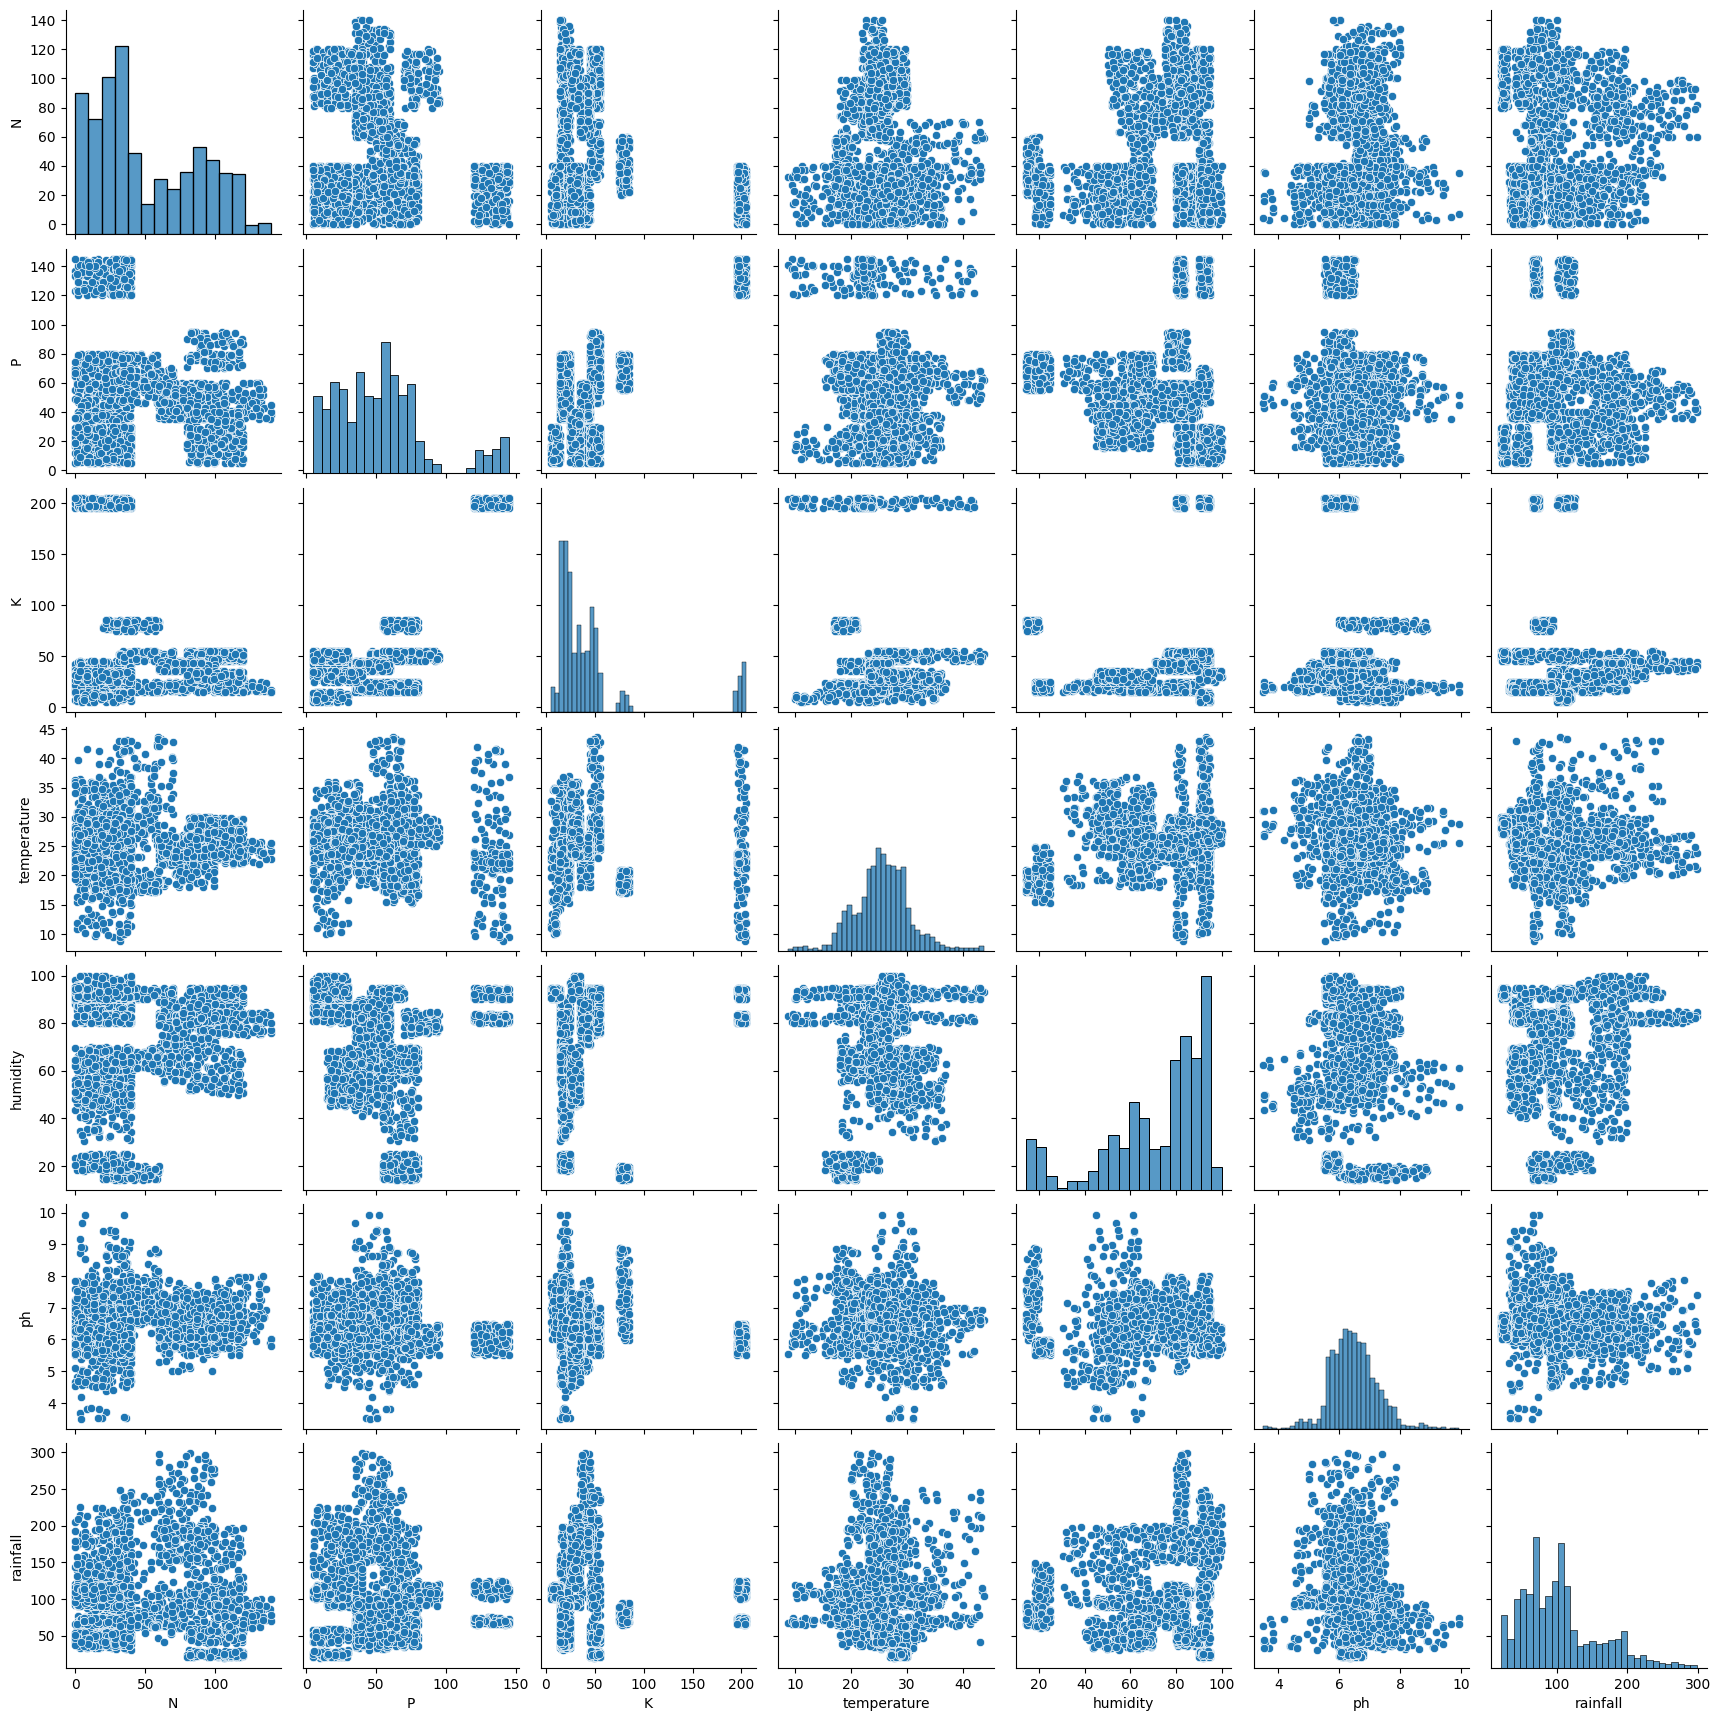

In [15]:
p = sns.pairplot(df)

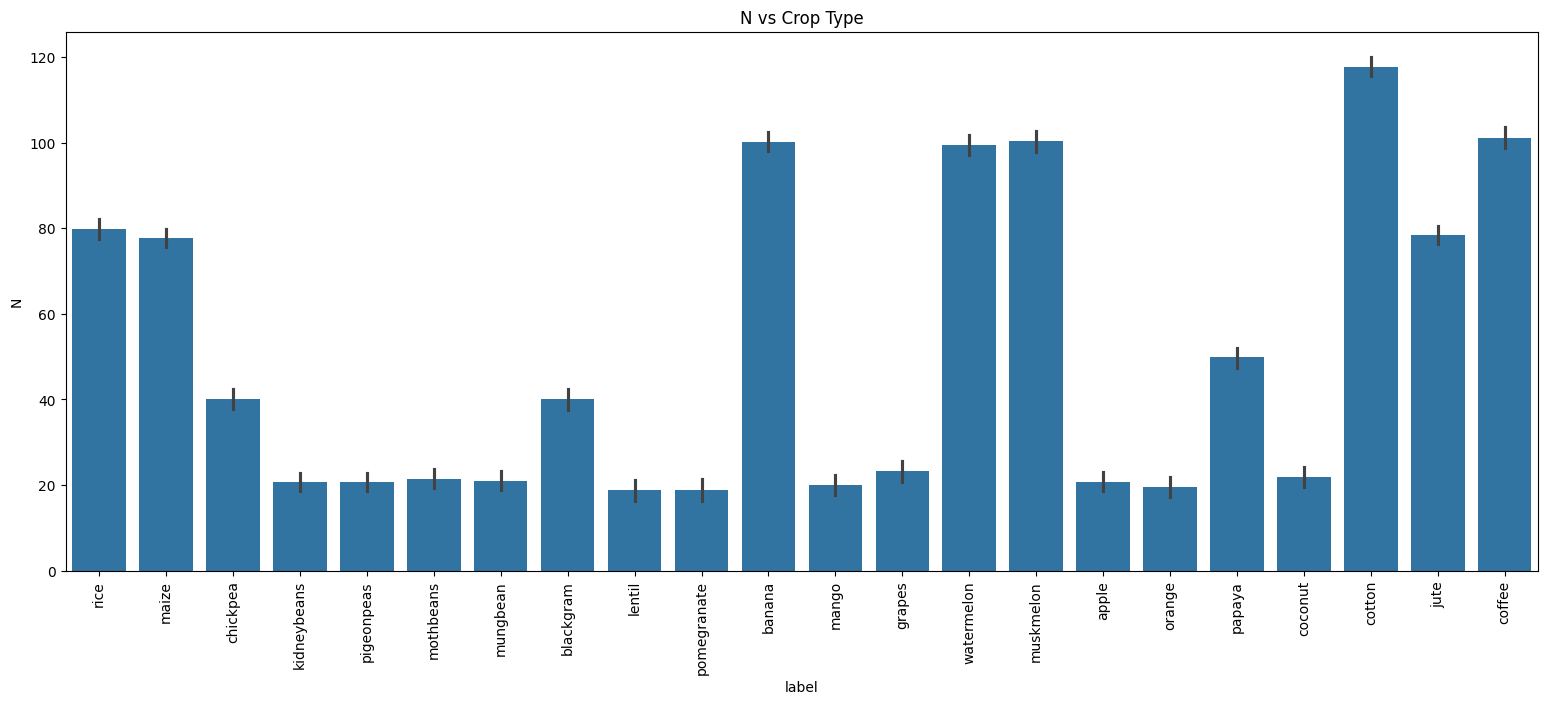

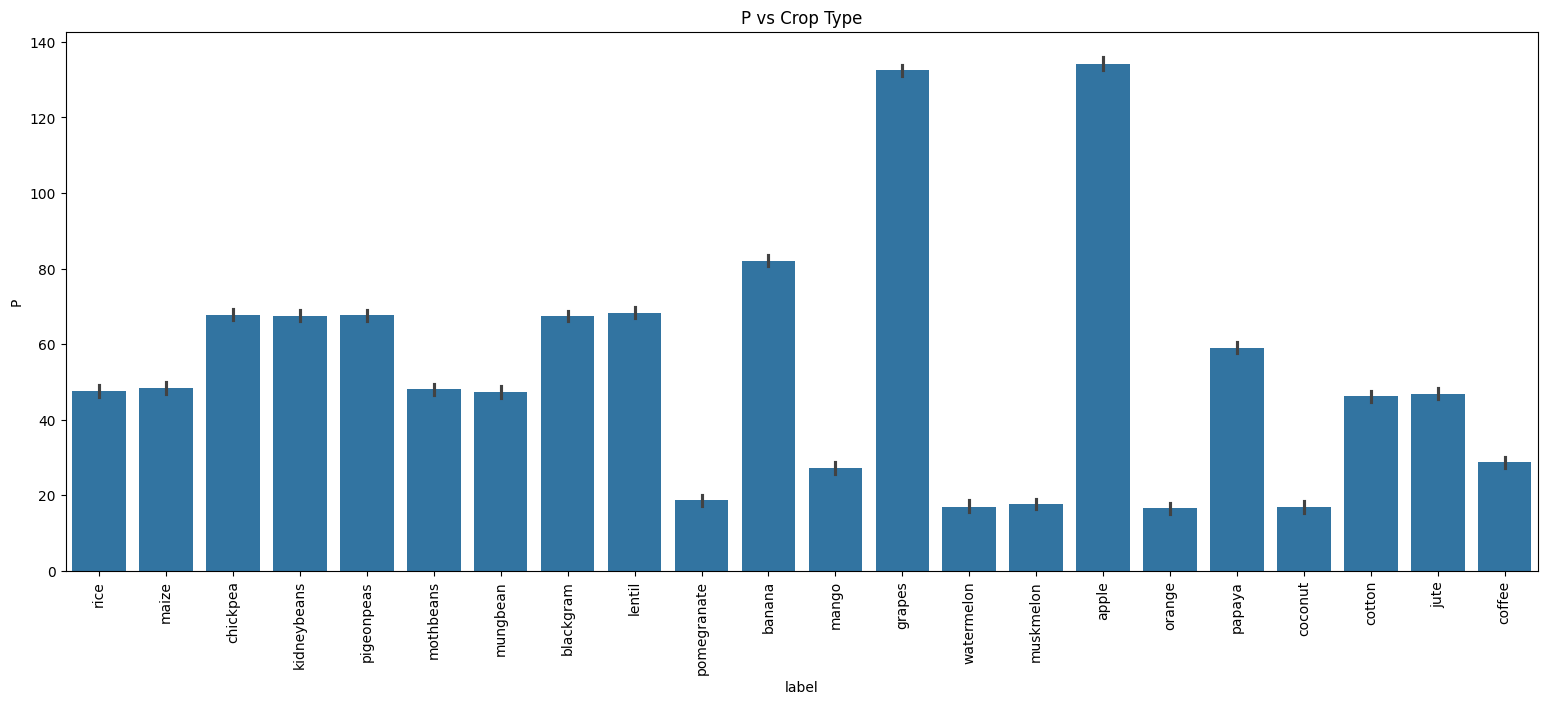

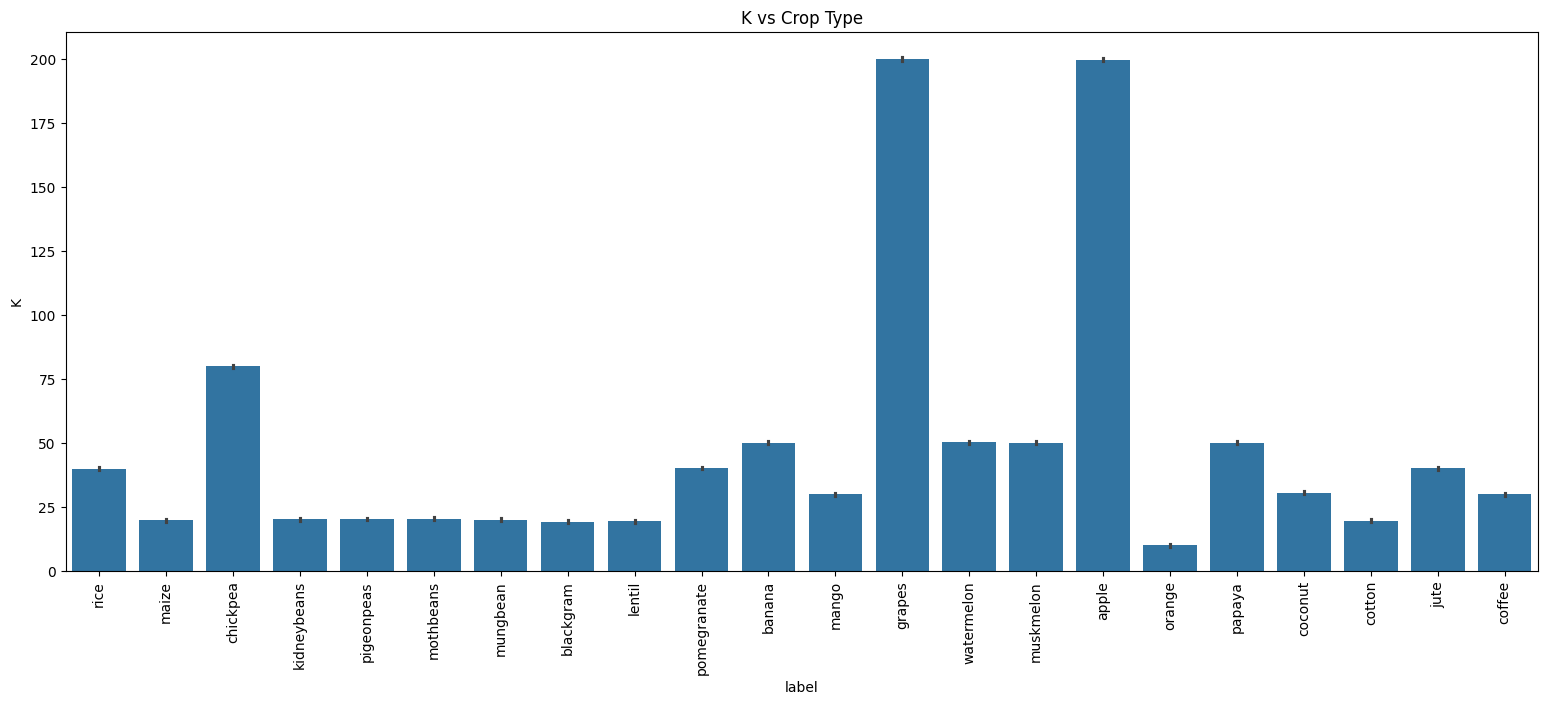

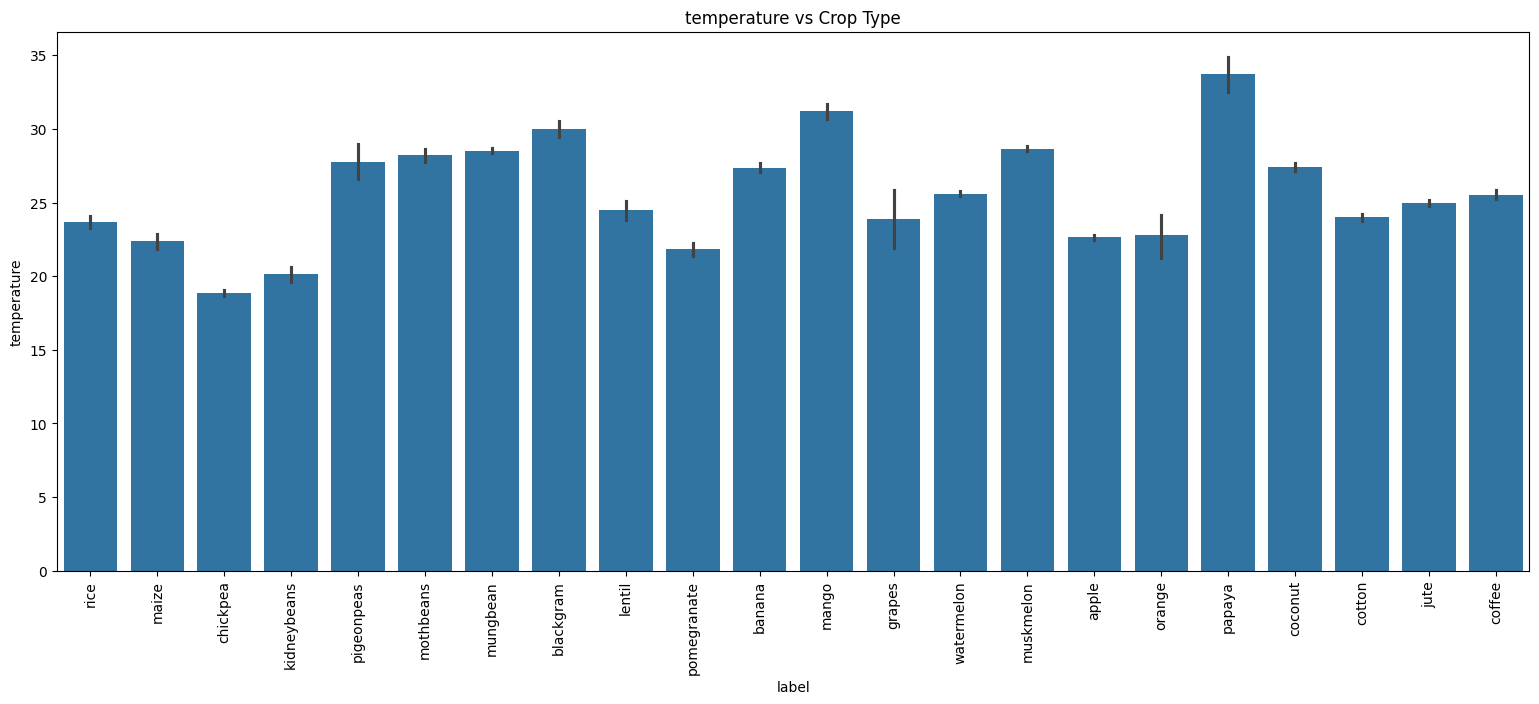

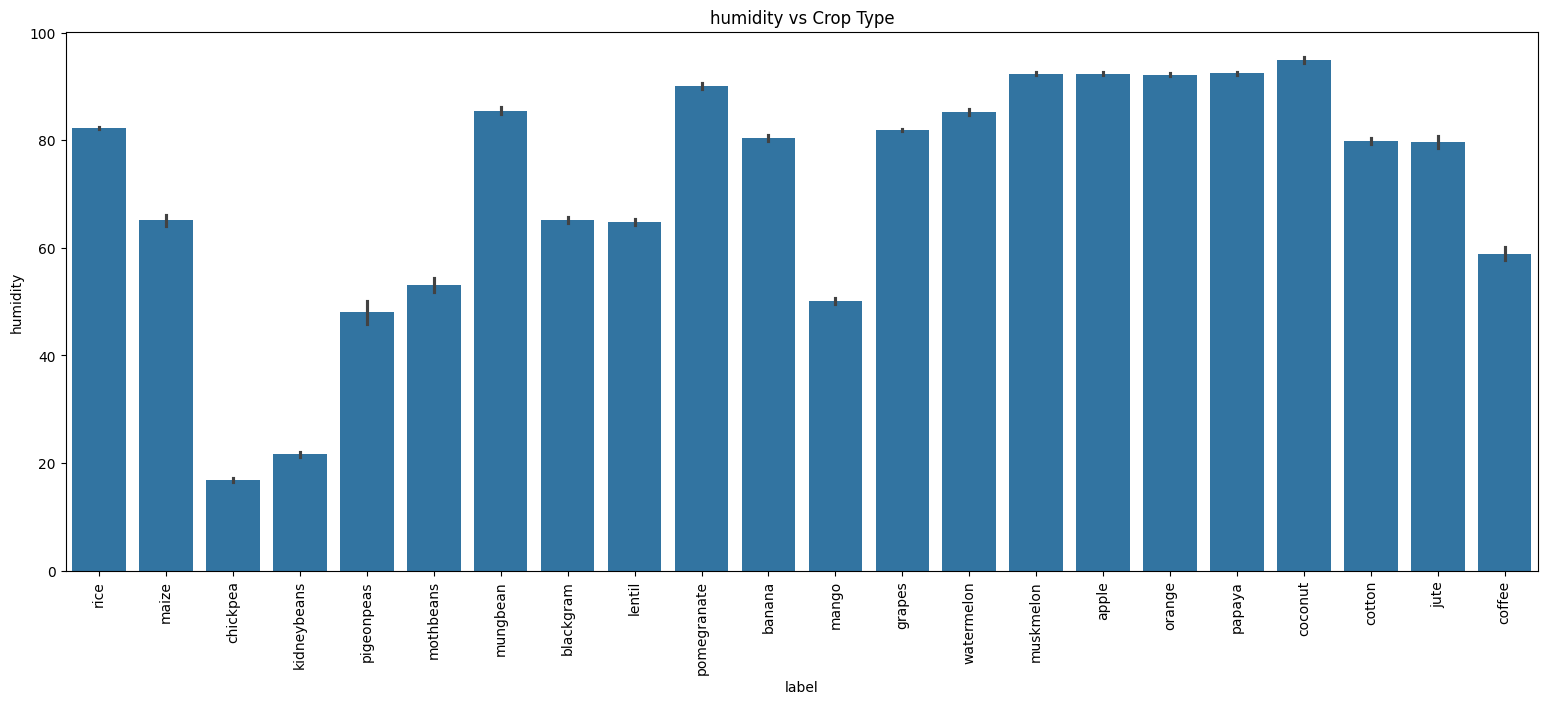

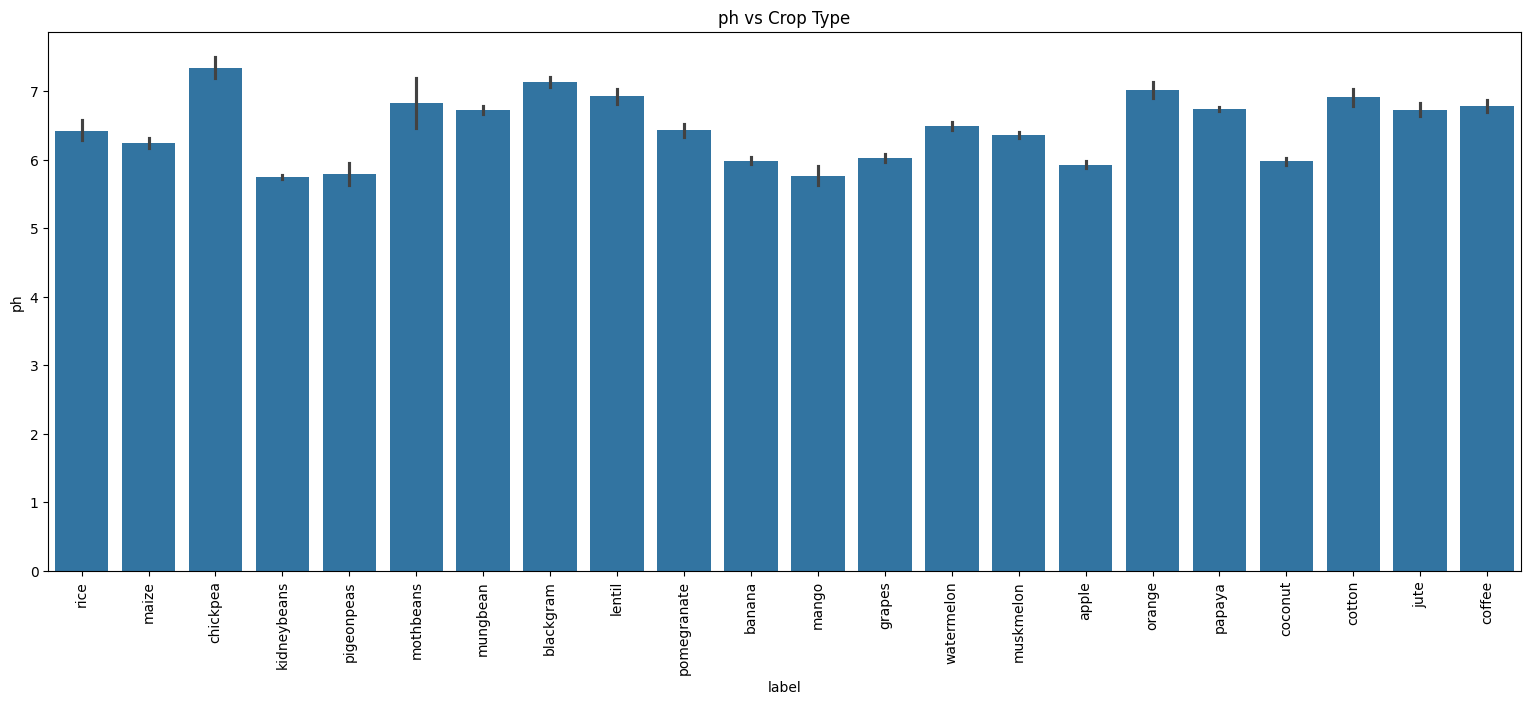

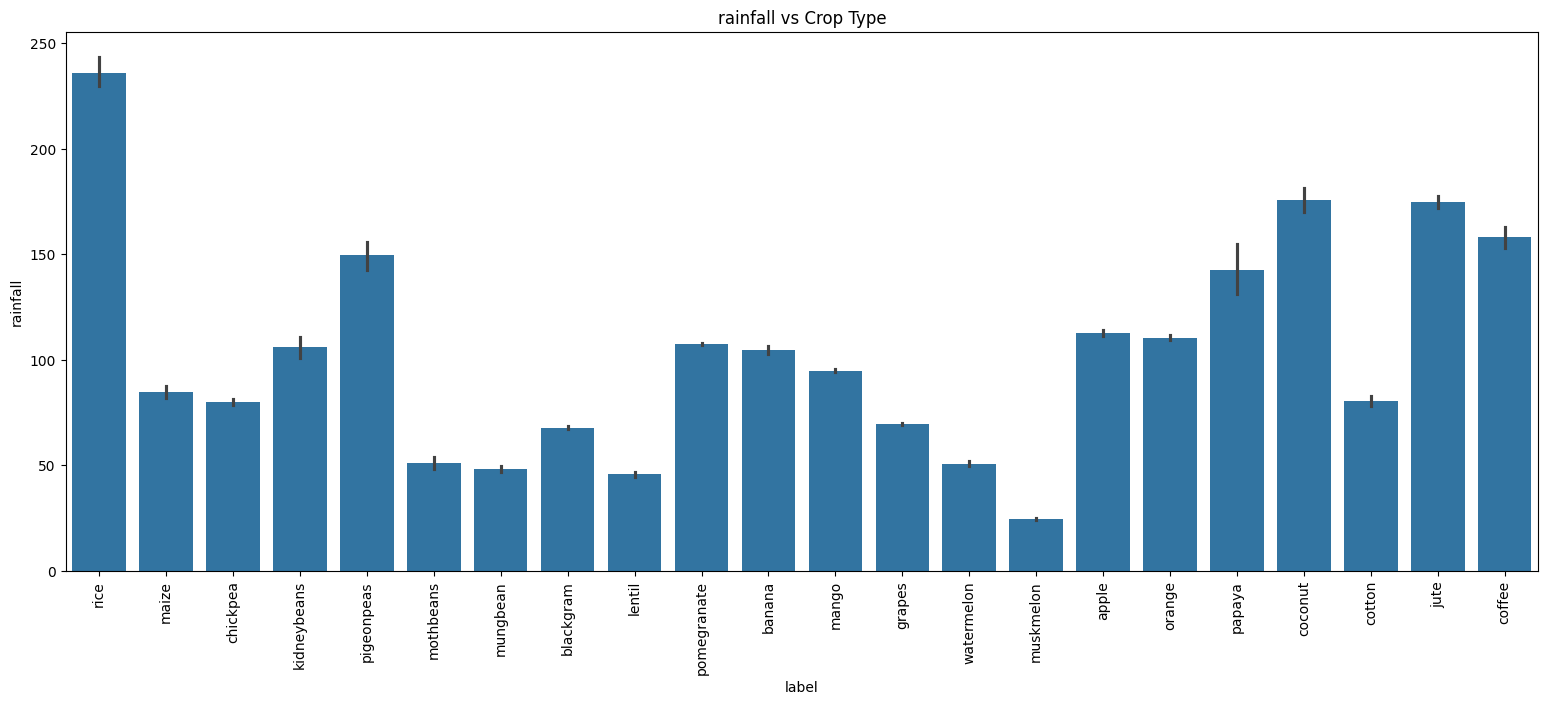

In [16]:
for column in all_columns:
    plt.figure(figsize=(19,7))
    sns.barplot(x = "label", y = column, data = df)
    plt.xticks(rotation=90)
    plt.title(f"{column} vs Crop Type")
    plt.show()

In [17]:

df  = shuffle(df,random_state=5)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon


#**Assumptions for Linear Regression**

##**1. Linearity**


c:\Users\LOURDHU RAJU\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


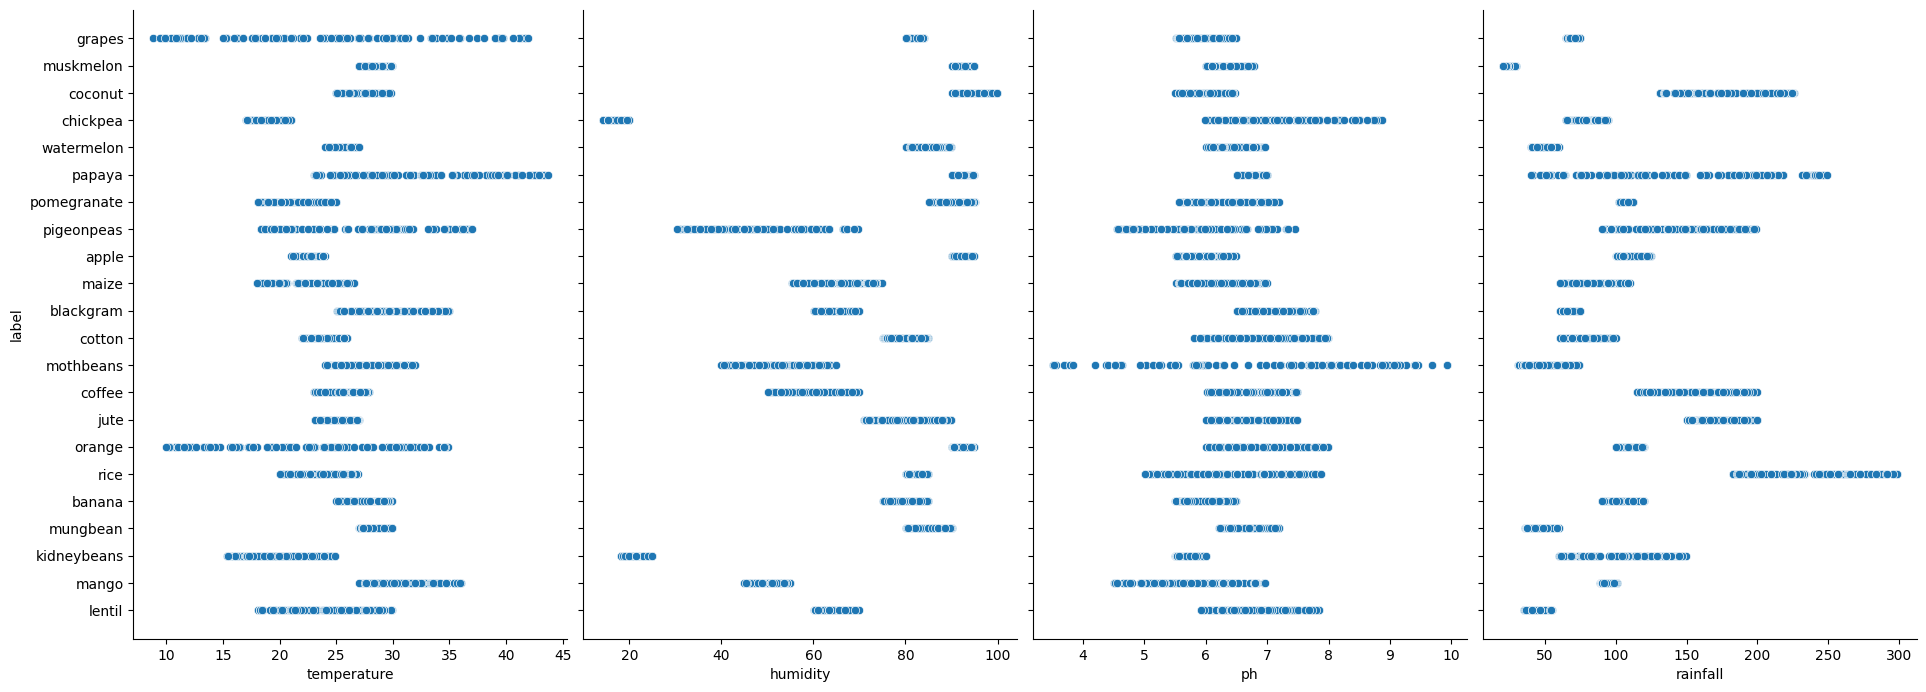

In [18]:
p = sns.pairplot(df, x_vars=['temperature',	'humidity',	'ph',	'rainfall'], y_vars='label', size=7, aspect=0.7)

c:\Users\LOURDHU RAJU\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


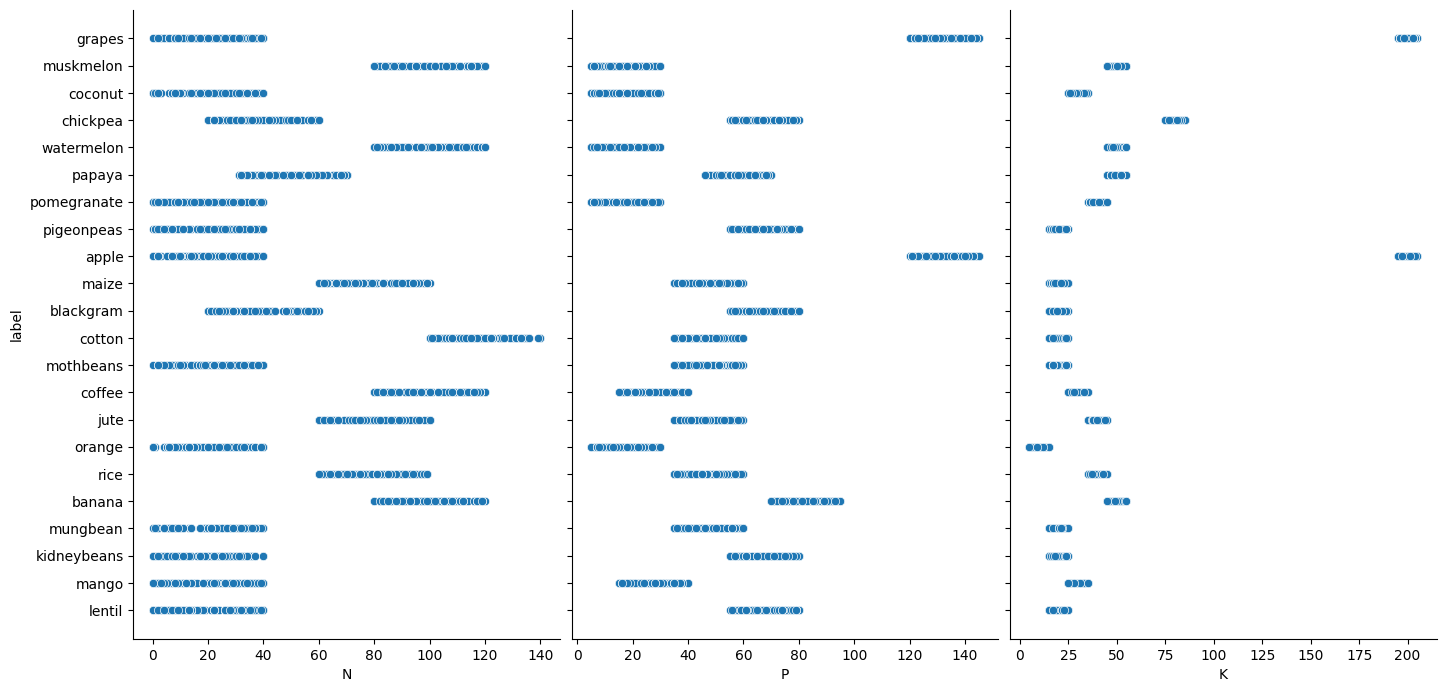

In [19]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(df, x_vars=['N',	'P',	'K'], y_vars='label', size=7, aspect=0.7)

#**Encoding target variable**


In [20]:
xdf = df.copy()
xdf

,N,P,K,temperature,humidity,ph,rainfall,label
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon
...,...,...,...,...,...,...,...,...
740,24,80,19,29.678925,69.085455,6.808042,65.664366,blackgram
1032,105,74,45,25.145176,81.382041,6.098369,119.218154,banana
2121,83,21,28,25.567483,60.492446,7.466901,190.225784,coffee
1424,102,25,50,28.204808,92.914404,6.099662,20.360011,muskmelon


In [21]:
labelencoder= LabelEncoder() # initializing an object of class LabelEncoder

#Fit and Transforming the label column.
xdf['label_codes'] = labelencoder.fit_transform(xdf['label']) 
xdf

,N,P,K,temperature,humidity,ph,rainfall,label,label_codes
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes,7
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon,15
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut,4
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea,3
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon,21
...,...,...,...,...,...,...,...,...,...
740,24,80,19,29.678925,69.085455,6.808042,65.664366,blackgram,2
1032,105,74,45,25.145176,81.382041,6.098369,119.218154,banana,1
2121,83,21,28,25.567483,60.492446,7.466901,190.225784,coffee,5
1424,102,25,50,28.204808,92.914404,6.099662,20.360011,muskmelon,15


In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming xdf is your DataFrame and labelencoder is your LabelEncoder
labelencoder = LabelEncoder()
xdf['label_codes'] = labelencoder.fit_transform(xdf['label']) 

# Get unique values of both original and encoded labels
unique_labels = xdf['label'].unique()
unique_label_codes = xdf['label_codes'].unique()

# Create a DataFrame to display side by side
label_comparison_df = pd.DataFrame({'Normal Label': unique_labels, 'Encoded Label': unique_label_codes})

# Display the DataFrame
print(label_comparison_df)


   Normal Label  Encoded Label
0        grapes              7
1     muskmelon             15
2       coconut              4
3      chickpea              3
4    watermelon             21
5        papaya             17
6   pomegranate             19
7    pigeonpeas             18
8         apple              0
9         maize             11
10    blackgram              2
11       cotton              6
12    mothbeans             13
13       coffee              5
14         jute              8
15       orange             16
16         rice             20
17       banana              1
18     mungbean             14
19  kidneybeans              9
20        mango             12
21       lentil             10


In [32]:
unique_labels = xdf['label_codes'].unique()
print(unique_labels)

[ 7 15  4  3 21 17 19 18  0 11  2  6 13  5  8 16 20  1 14  9 12 10]


In [22]:
# Selection of Feature and Target variables.

x = df[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = df['label']

In [23]:
# Encoding target variable 

y = pd.get_dummies(target)
y

,apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,...,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
1270,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1481,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1832,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
293,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1032,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2121,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1424,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25, random_state= 0)

print("x_train :",x_train.shape)
print("x_test :",x_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

x_train : (1650, 7)
x_test : (550, 7)
y_train : (1650, 22)
y_test : (550, 22)


**TRAINING**


In [25]:
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=-1)

In [26]:
# Predicting test results 

forest_pred = multi_target_forest.predict(x_test)
forest_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False]])

In [27]:
# Calculating Accuracy

from sklearn.metrics import accuracy_score
a1 = accuracy_score(y_test, forest_pred)
print('Accuracy score:', accuracy_score(y_test, forest_pred))

Accuracy score: 0.98


**Cross-validation**


In [28]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(multi_target_forest,X = x_train, y = y_train,cv=5)
score


array([0.97575758, 0.96666667, 0.95454545, 0.96666667, 0.96969697])

In [29]:
print("Accuracy : {:.2f}%".format (score.mean()*100))
print("Standard Deviation : {:.2f}%".format(score.std()*100))

Accuracy : 96.67%
Standard Deviation : 0.69%


In [30]:
import pickle
# Dump the trained Naive Bayes classifier with Pickle
RF_pkl_filename = 'model.pkl'
# Open the file to save as pkl file
RF_Model_pkl = open(RF_pkl_filename, 'wb')
pickle.dump(multi_target_forest, RF_Model_pkl)
# Close the pickle instances
RF_Model_pkl.close()